# 2d Finite-difference Matrices

In this notebook, we use Kronecker products to construct a 2d finite-difference approximation of the Laplacian operator $-\nabla^2$ with Dirichlet (zero) boundary conditions, via the standard 5-point stencil (centered differences in $x$ and $y$).

## Kronecker products

Kronecker products are computed in Julia (for sparse or dense matrices) via the `kron(A,B)` function, which returns $A \otimes B$:

In [1]:
M = [1 2 3
     4 5 6]
kron(eye(2,2), M)

4x6 Array{Float64,2}:
 1.0  2.0  3.0  0.0  0.0  0.0
 4.0  5.0  6.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  2.0  3.0
 0.0  0.0  0.0  4.0  5.0  6.0

We can also use the standard symbol $\otimes$ as an infix operator (type it as `\otimes<TAB>` in the notebook):

In [2]:
const ⊗ = kron

M ⊗ eye(2,2)

4x6 Array{Float64,2}:
 1.0  0.0  2.0  0.0  3.0  0.0
 0.0  1.0  0.0  2.0  0.0  3.0
 4.0  0.0  5.0  0.0  6.0  0.0
 0.0  4.0  0.0  5.0  0.0  6.0

Let's check the mixed-product identity that I asked you to prove for homework:

In [3]:
A = rand(3,3); B = rand(3,3); C = rand(3,3); D = rand(3,3)
norm((A⊗B)*(C⊗D) - (A*C)⊗(B*D))

4.882786982824487e-16

## 2d Laplacian Matrix

The Kronecker products build up the matrix acting on "multidimensional" data from the matrices expressing the 1d operations on a 1d finite-difference grid.  We start with the first-derivative matrix $D$ from class.

In [4]:
# construct the (M+1)xM matrix D, not including the 1/dx factor
diff1(M) = [ [1.0 zeros(1,M-1)]; diagm(ones(M-1),1) - eye(M) ]

diff1 (generic function with 1 method)

In [5]:
diff1(5)

6x5 Array{Float64,2}:
  1.0   0.0   0.0   0.0   0.0
 -1.0   1.0   0.0   0.0   0.0
  0.0  -1.0   1.0   0.0   0.0
  0.0   0.0  -1.0   1.0   0.0
  0.0   0.0   0.0  -1.0   1.0
  0.0   0.0   0.0   0.0  -1.0

Multidimensional finite-difference matrices will quickly get very large, so we need to exploit the fact that they are *sparse* (mostly zero), but storing only the nonzero entries and using special algorithms that exploit the sparsity.  A sparse matrix can be constructed in Julia by using the `sparse` function:

In [6]:
# sparse version (the lazy way):
sdiff1(M) = sparse(diff1(M))
sdiff1(5)

6x5 sparse matrix with 10 Float64 entries:
	[1, 1]  =  1.0
	[2, 1]  =  -1.0
	[2, 2]  =  1.0
	[3, 2]  =  -1.0
	[3, 3]  =  1.0
	[4, 3]  =  -1.0
	[4, 4]  =  1.0
	[5, 4]  =  -1.0
	[5, 5]  =  1.0
	[6, 5]  =  -1.0

Now we'll construct the matrix approximation of $-\nabla^2$ in 2d for an $L_x \times L_y$ box with Dirichlet boundary conditions.  The unknowns are discretized into $N_x \times N_y$ points, are assumed to be written as column vectors in "column-major" order (a stack of $N_y$ vectors of length $N_x$), as described in the lecture notes.

The function `kron` computes the Kronecker product, and the function `speye(N)` forms the $N \times N$ identity matrix $I_N$ in sparse-matrix format.  As in the notes, this gives us $A = I_{N_y} \otimes A_x + A_y \otimes I_{N_x}$.

In [7]:
# make the discrete -Laplacian in 2d, with Dirichlet boundaries
function Laplacian(Nx, Ny, Lx, Ly)
   dx = Lx / (Nx+1)
   dy = Ly / (Ny+1)
   Dx = sdiff1(Nx) / dx
   Dy = sdiff1(Ny) / dy
   Ax = Dx' * Dx
   Ay = Dy' * Dy
   return kron(speye(Ny), Ax) + kron(Ay, speye(Nx))
end

Laplacian (generic function with 1 method)

The `spy` command lets us plot the nonzero pattern in a matrix.  (Currently, `spy` does not work on Julia's sparse-matrix datastructure, so we use the `full` function to convert it back to an ordinary "dense" matrix first.)

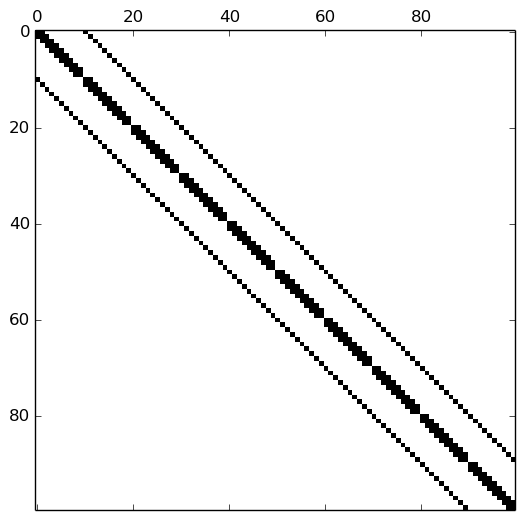

PyObject <matplotlib.image.AxesImage object at 0x7f7798340d10>

In [8]:
using PyPlot
spy(full(Laplacian(10,10,1,1)))

## Eigenfunctions in a rectangular box

As a first test case, we'll consider a rectangular box and find its eigenvalues and eigenfunctions.  From class, we know that $-\nabla^2$ in this domain has separable eigenfunctions $\sin(n_x \pi x / L_x) \sin(n_y \pi y / L_y)$ with eigenvalues $(n_x \pi / L_x)^2 + (n_y \pi / L_y)^2$.  We'll use $L_x = 1$ and $L_y = 2$.

In [9]:
Lx = 1
Ly = 2
Nx = 50
Ny = 100
x = linspace(0,Lx,Nx+2)[2:end-1]
y = linspace(0,Ly,Ny+2)[2:end-1]'
A = Laplacian(Nx,Ny,Lx,Ly)

5000x5000 sparse matrix with 24700 Float64 entries:
	[1   ,    1]  =  10302.5
	[2   ,    1]  =  -2601.0
	[51  ,    1]  =  -2550.25
	[1   ,    2]  =  -2601.0
	[2   ,    2]  =  10302.5
	[3   ,    2]  =  -2601.0
	[52  ,    2]  =  -2550.25
	[2   ,    3]  =  -2601.0
	[3   ,    3]  =  10302.5
	[4   ,    3]  =  -2601.0
	⋮
	[4948, 4998]  =  -2550.25
	[4997, 4998]  =  -2601.0
	[4998, 4998]  =  10302.5
	[4999, 4998]  =  -2601.0
	[4949, 4999]  =  -2550.25
	[4998, 4999]  =  -2601.0
	[4999, 4999]  =  10302.5
	[5000, 4999]  =  -2601.0
	[4950, 5000]  =  -2550.25
	[4999, 5000]  =  -2601.0
	[5000, 5000]  =  10302.5

The `eigs` function exploits the sparsity of `A` to find only a *few* of the eigenvalues and eigenvectors.  `which="SM" nev=6` means that we are requesting the smallest-magnitude **6** eigenvalues.  This is *far* more efficient than computing *all* of the eigenvalues and eigenvectors via `eig` for large sparse matrices.

In [10]:
λ, U = eigs(A, which=:SM, nev=6)

([12.333686079612542,19.732905729999747,32.056984593918415,41.895710856306,49.293999921005835,49.294930506693255],
5000x6 Array{Float64,2}:
 -5.33516e-5   -0.000106652  -0.000159848  …   0.000212891  0.000212899
 -0.000106501  -0.000212899  -0.000319091      0.000424974  0.00042257 
 -0.000159246  -0.000318338  -0.000477122      0.000635445  0.000625836
 -0.000211387  -0.00042257   -0.000633344      0.000843505  0.000819614
 -0.000262727  -0.000525199  -0.000787163      0.00104837   0.00100097 
 -0.000313069  -0.000625836  -0.000937997  …   0.00124925   0.00116715 
 -0.000362224  -0.000724098  -0.00108527       0.0014454    0.00131564 
 -0.000410006  -0.000819614  -0.00122843       0.00163606   0.00144418 
 -0.000456231  -0.000912021  -0.00136693       0.00182051   0.00155083 
 -0.000500726  -0.00100097   -0.00150024       0.00199806   0.00163397 
 -0.000543322  -0.00108612   -0.00162786   …   0.00216804   0.00169235 
 -0.000583857  -0.00116715   -0.00174931       0.00232978   0.001725

Let's check that $\lambda_1$, the smallest-magnitude eigenvalue of the finite-difference approximation, is close to the analytical value $(\pi/L_x)^2 + (\pi/L_y)^2$:

In [11]:
λ[1], (pi/Lx)^2 + (pi/Ly)^2

(12.333686079612542,12.337005501361698)

The expression `U[:,2]` gives the second column of `U`, i.e. the eigenvector corresponding to the second-smallest magnitude $\lambda$.  Since it is in column-major order can convert this back to a 2d $N_x \times N_y$ matrix by the reshape command, and plot it with `imshow` from `PyPlot`: 

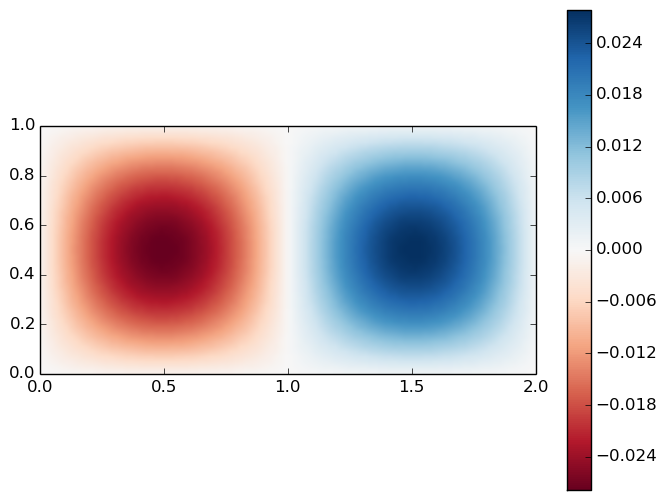

PyObject <matplotlib.colorbar.Colorbar instance at 0x7f7797ea1950>

In [12]:
imshow(reshape(U[:,2], Nx,Ny), extent=[0,Ly,0,Lx], cmap="RdBu")
colorbar()

## Eigenfunctions in a cylinder

Next, we'll consider the case from class of $-\nabla^2$ in a radius-$1$ cylinder centered on the origin.

To construct the finite-difference matrix, we'll first construct the finite-difference matrix $A$ for the box $[-1,1] \times [-1,1]$.  Setting the unknowns to zero outside the cylinder corresponds to deleting the corresponding *columns* of $A$, and ignoring $-\nabla^2$ outside the cylinder corresponds to deleting the corresponding *rows* of $A$.  We use the `find` function to get an array `i` of the indices for all points inside the cylinder (radius $r < 1$), and then make the submatrix `Ai` of those rows and columns via `A[i,i]`.  Neat, huh?

In [13]:
Lx = 1
Ly = 1
Nx = 100
Ny = 100
x = linspace(-Lx,Lx,Nx+2)[2:end-1]   # a column vector
y = linspace(-Ly,Ly,Ny+2)[2:end-1]'  # a row vector
r = sqrt(x.^2 .+ y.^2)   # use broadcasting (.+) to make Nx x Ny matrix of radii
i = find(r .< 1)         # and get indices of points inside the cylinder
A = Laplacian(Nx,Ny,2Lx,2Ly)
Ai = A[i,i]              # to make a submatrix for the Laplacian inside the cylinder
λi, Ui = eigs(Ai, which=:SM, nev=6);

To plot the resulting eigenfunctions, we must first convert them back into a rectangular grid of points.  We make a 2d array `u` of zeros (since the functions are zero outside the cylinder), and set `u[i] = Ui[:,2]` to set the points *inside* the cylinder to the second column of `U`, i.e. to the eigenvector for the second-largest $\lambda$.   We then plot it with `imshow` as before, with a superimposed contour plot to show the outline of the cylinder:

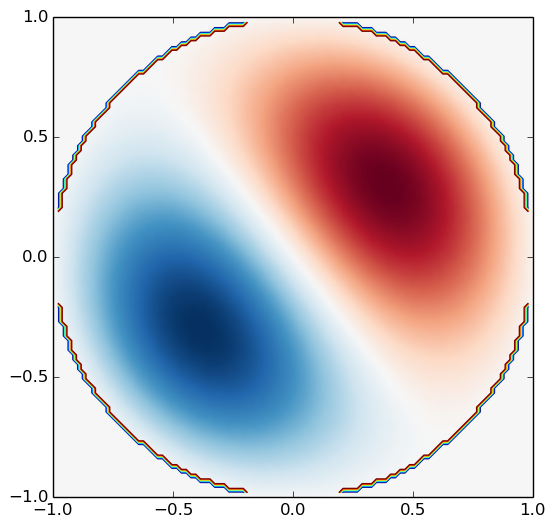

PyObject <matplotlib.contour.QuadContourSet instance at 0x7f7797df2830>

In [14]:
u = zeros(Nx,Ny)
u[i] = Ui[:,2]
imshow(u, extent=[-Ly,Ly,-Lx,Lx], cmap="RdBu")
contour(y,x, (r.<1) * 1.0)

Notice that, as could be checked from the analytical solution, the second-largest $\lambda$ corresponds to an eigenfunction $J_1(k_{11} r) \cos(\theta + \mathrm{some angle})$.  (Note that this eigenvalue is of multiplicity 2, and `eigs` returns a "random" superposition of the $\sin$ and $\cos$ solutions.)

Let's check that the eigenvalues are indeed squares of roots of Bessel functions, from class.  For example, the smallest $\lambda$ should be the square of the first root of $J_0(x)$.  Let's plot $J_0(x)$ and find the first root squared along with the computed first $\lambda$:

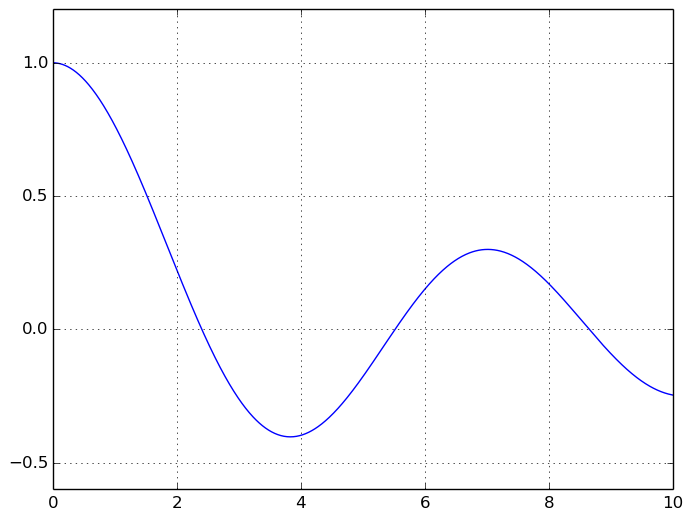

(5.783185962946783,5.706201120276575)

In [15]:
using PyCall
@pyimport scipy.optimize as so
plot(0:0.01:10, besselj(0,0:0.01:10))
grid()
so.newton(x -> besselj(0,x), 2.0)^2, λi[1]

The eigenvalues match pretty well, to the accuracy of the finite-difference approximation!

## Eigenfunctions of a weird shape

Both of the above examples (box, cylinder) can be solved analytically via separation of variables.  But, of course, the computer is perfectly happy solving a domain that cannot be dealt with analytically.  For example, here is a domain with a spiral boundary:

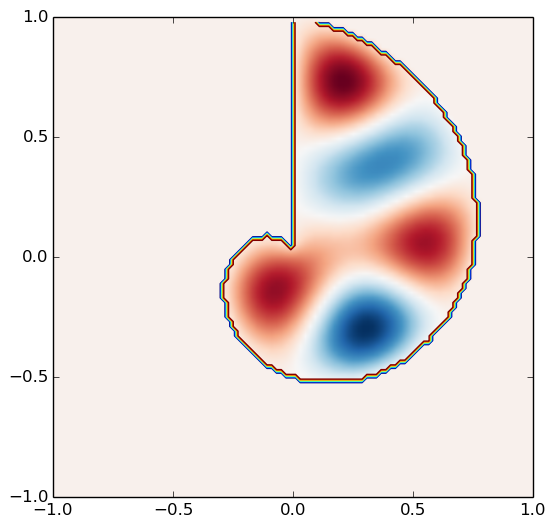

PyObject <matplotlib.contour.QuadContourSet instance at 0x7f7792d26bd8>

In [16]:
Lx = 1
Ly = 1
Nx = 100
Ny = 100
x = linspace(-Lx,Lx,Nx+2)[2:end-1]   # a column vector
y = linspace(-Ly,Ly,Ny+2)[2:end-1]'  # a row vector
θ = broadcast(atan2, y, x)
r = sqrt(x.^2 .+ y.^2)   # use broadcasting (.+) to make Nx x Ny matrix of radii
Ω = r .< (θ + pi)/(2pi)
i = find(Ω)         # and get indices of points inside the domain
A = Laplacian(Nx,Ny,2Lx,2Ly)
Ai = A[i,i]              # to make a submatrix for the Laplacian inside the domain
λi, Ui = eigs(Ai, which=:SM, nev=6);
u = zeros(Nx,Ny)
u[i] = Ui[:,6]
imshow(u, extent=[-Ly,Ly,-Lx,Lx], cmap="RdBu")
contour(y,x, (flipdim(Ω,1)) * 1.0)